In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from itertools import cycle
from sklearn.svm import SVC

%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

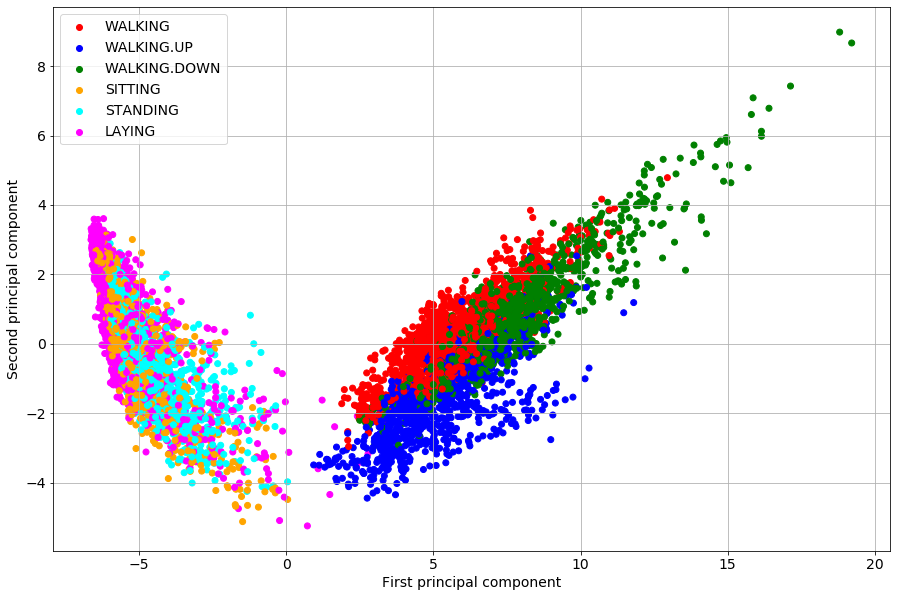

In [3]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

In [4]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [5]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


In [6]:
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.var_model import VAR

In [7]:
%%time
X_train_new = []
for x in X_train:
    model = VAR(x)
    results = model.fit()
    X_train_new.append(results.params)
X_train_new = np.array(X_train_new)

CPU times: user 4.94 s, sys: 39.5 ms, total: 4.98 s
Wall time: 5.01 s


In [8]:
%%time
X_test_new = []
for x in X_test:
    model = VAR(x)
    results = model.fit()
    X_test_new.append(results.params)
X_test_new = np.array(X_test_new)

CPU times: user 1.9 s, sys: 8.4 ms, total: 1.9 s
Wall time: 1.91 s


In [9]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten

Using TensorFlow backend.


In [10]:
from keras.utils import to_categorical
from keras.utils import np_utils

In [11]:
def get_all_results(model, parameters, x_train, y_train, x_test, y_test):
    gridsearch = GridSearchCV(model(), parameters, n_jobs=2)
    gridsearch.fit(X_train_new, y_train_new)
    print(gridsearch.best_params_)
    
    params = dict(gridsearch.best_params_)
    clf = model(**params)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(classification_report(y_test, y_pred))
    
    classifier = OneVsRestClassifier(model(**params))
    try:
        y_score = classifier.fit(X_train_new, Y_train_new).decision_function(X_test_new)
    except:
        y_score = clf.predict_proba(X_test_new)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test_new[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    lw = 2
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    # Plot all ROC curves
    plt.figure(figsize=(13,10))

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'black'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve ' + str(clf).split('(')[0])
    plt.legend(loc="lower right")
    plt.show()

In [12]:
X_train_new = X_train_new.reshape(X_train_new.shape[0], 10*9)
X_train_new = X_train_new.astype('float32')
X_train_new /= np.amax(X_train_new)
y_train_new = y_train.reshape(-1)
Y_train_new = np_utils.to_categorical(y_train, 6)

In [13]:
X_test_new = X_test_new.reshape(X_test_new.shape[0], 10*9)
X_test_new = X_test_new.astype('float32')
X_test_new /= np.amax(X_test_new)
y_test_new = y_test.reshape(-1)
Y_test_new = np_utils.to_categorical(y_test_new, 6)

In [14]:
from keras.wrappers.scikit_learn import KerasClassifier

In [15]:
def build_model():
    model = Sequential()
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(6, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [16]:
keras_model = build_model()

In [17]:
%%time
keras_model.fit(X_train_new, Y_train_new, epochs=100, validation_split=0.1, batch_size=16, shuffle=True)

Train on 6616 samples, validate on 736 samples
Epoch 1/100
6616/6616 [==============================] - 2s 271us/step - loss: 1.6448 - accuracy: 0.2973 - val_loss: 1.4943 - val_accuracy: 0.3234
Epoch 2/100
6616/6616 [==============================] - 1s 159us/step - loss: 1.4544 - accuracy: 0.3489 - val_loss: 1.3205 - val_accuracy: 0.3818
Epoch 3/100
6616/6616 [==============================] - 1s 159us/step - loss: 1.3796 - accuracy: 0.3962 - val_loss: 1.2540 - val_accuracy: 0.4674
Epoch 4/100
6616/6616 [==============================] - 1s 156us/step - loss: 1.2946 - accuracy: 0.4460 - val_loss: 1.2019 - val_accuracy: 0.5082
Epoch 5/100
6616/6616 [==============================] - 1s 157us/step - loss: 1.2271 - accuracy: 0.5008 - val_loss: 1.1268 - val_accuracy: 0.5598
Epoch 6/100
6616/6616 [==============================] - 1s 161us/step - loss: 1.1723 - accuracy: 0.5333 - val_loss: 1.1133 - val_accuracy: 0.5530
Epoch 7/100
6616/6616 [==============================] - 1s 158us/step 

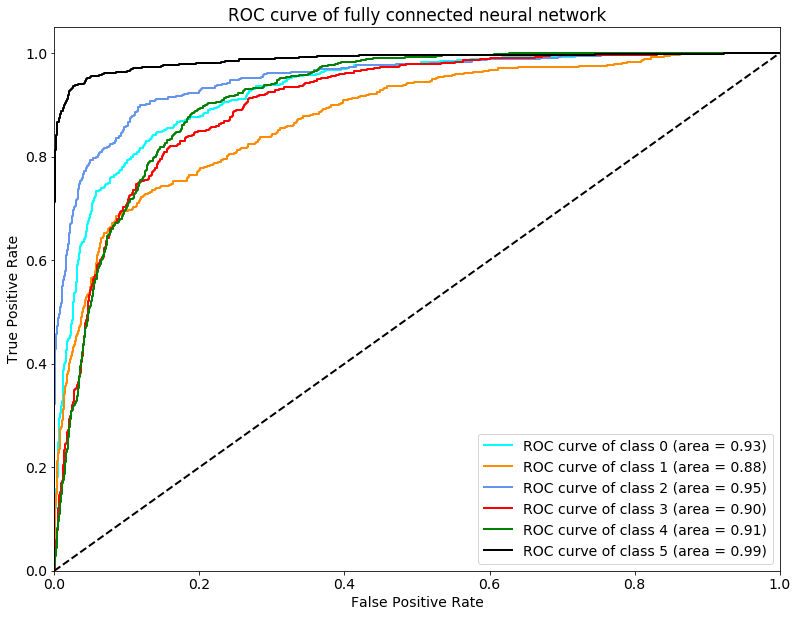

In [18]:
y_score = keras_model.predict(X_test_new)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_new[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

# Plot all ROC curves
plt.figure(figsize=(13,10))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of fully connected neural network')
plt.legend(loc="lower right")
plt.show()

# Gradient Boosting Classifier

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

/Users/igor/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'learning_rate': 0.1, 'n_estimators': 150}
              precision    recall  f1-score   support

           0       0.82      0.68      0.74       496
           1       0.57      0.93      0.71       471
           2       0.84      0.72      0.78       420
           3       0.75      0.66      0.70       491
           4       0.77      0.70      0.73       532
           5       0.89      0.83      0.86       537

    accuracy                           0.75      2947
   macro avg       0.77      0.75      0.75      2947
weighted avg       0.78      0.75      0.75      2947



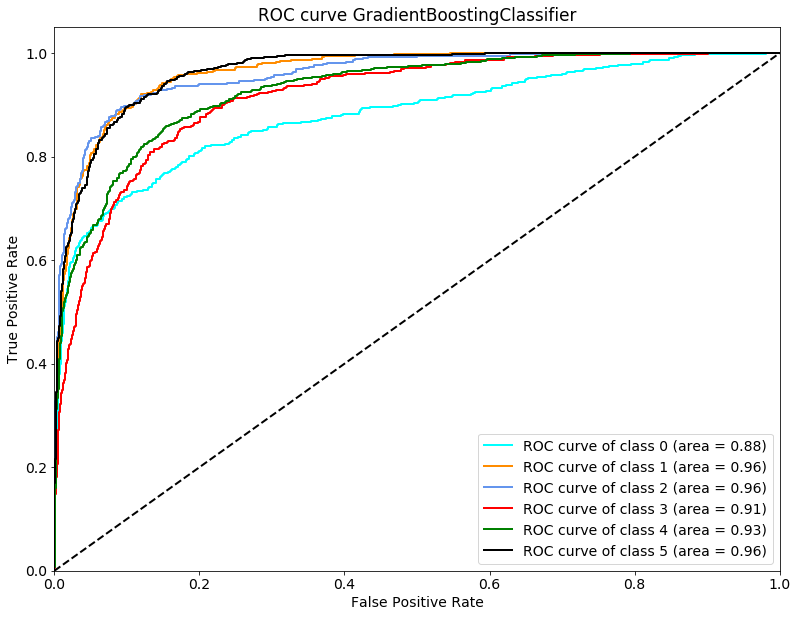

CPU times: user 2min 27s, sys: 577 ms, total: 2min 28s
Wall time: 7min 45s


In [22]:
%%time
parameters = {'learning_rate': [0.02, 0.05, 0.1], 'n_estimators': [50, 100, 150]}
get_all_results(GradientBoostingClassifier, parameters, X_train_new, y_train_new,
                X_test_new, y_test_new)

# SVM

/Users/igor/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.55      0.43      0.48       496
           1       0.60      0.37      0.46       471
           2       0.71      0.56      0.63       420
           3       0.12      0.00      0.00       491
           4       0.32      0.16      0.21       532
           5       0.31      0.96      0.47       537

    accuracy                           0.41      2947
   macro avg       0.44      0.41      0.38      2947
weighted avg       0.43      0.41      0.37      2947



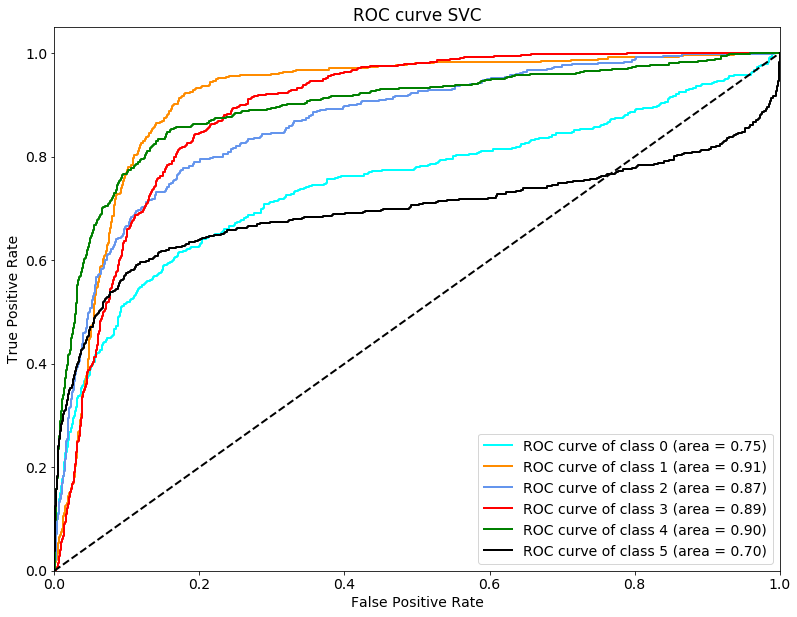

CPU times: user 30.3 s, sys: 308 ms, total: 30.6 s
Wall time: 57.5 s


In [25]:
%%time
parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
get_all_results(SVC, parameters, X_train_new, y_train_new, X_test_new, y_test_new)

# KNeighborsClassifier

In [26]:
from sklearn.neighbors import KNeighborsClassifier

/Users/igor/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/igor/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'algorithm': 'ball_tree', 'n_neighbors': 10}
              precision    recall  f1-score   support

           0       0.59      0.53      0.56       496
           1       0.52      0.40      0.46       471
           2       0.68      0.56      0.61       420
           3       0.49      0.59      0.54       491
           4       0.47      0.58      0.52       532
           5       0.79      0.77      0.78       537

    accuracy                           0.58      2947
   macro avg       0.59      0.57      0.58      2947
weighted avg       0.59      0.58      0.58      2947



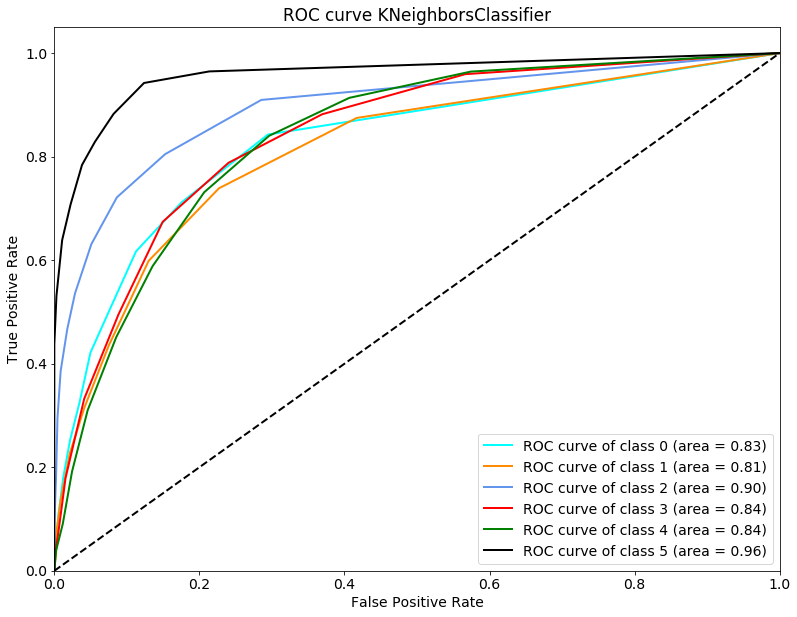

CPU times: user 5.57 s, sys: 71.2 ms, total: 5.64 s
Wall time: 24.2 s


In [27]:
%%time
parameters = {'n_neighbors': [3, 5, 7, 10], 'algorithm': ['ball_tree', 'kd_tree', 'brute']}
get_all_results(KNeighborsClassifier, parameters, X_train_new, y_train_new, X_test_new, y_test_new)

# Random Forest Classifier

In [28]:
from sklearn.ensemble import RandomForestClassifier

/Users/igor/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'bootstrap': True, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.73      0.66      0.69       496
           1       0.64      0.76      0.69       471
           2       0.75      0.72      0.74       420
           3       0.70      0.64      0.67       491
           4       0.71      0.73      0.72       532
           5       0.80      0.82      0.81       537

    accuracy                           0.72      2947
   macro avg       0.72      0.72      0.72      2947
weighted avg       0.72      0.72      0.72      2947



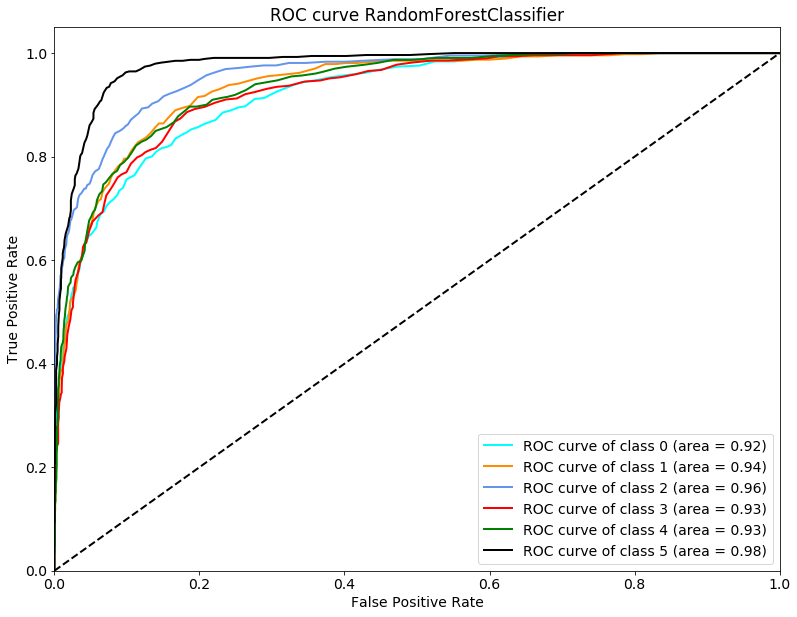

CPU times: user 1min 15s, sys: 215 ms, total: 1min 16s
Wall time: 2min 19s


In [29]:
%%time
parameters = {'n_estimators': [100, 150, 200], 'bootstrap': [True, False]}
get_all_results(RandomForestClassifier, parameters, X_train_new, y_train_new, X_test_new, y_test_new)

# AdaBoostClassifier

In [30]:
from sklearn.ensemble import AdaBoostClassifier

/Users/igor/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'learning_rate': 1.0, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.76      0.63      0.69       496
           1       0.57      0.87      0.69       471
           2       0.78      0.70      0.74       420
           3       0.55      0.59      0.57       491
           4       0.67      0.58      0.62       532
           5       0.77      0.64      0.70       537

    accuracy                           0.67      2947
   macro avg       0.68      0.67      0.67      2947
weighted avg       0.68      0.67      0.67      2947



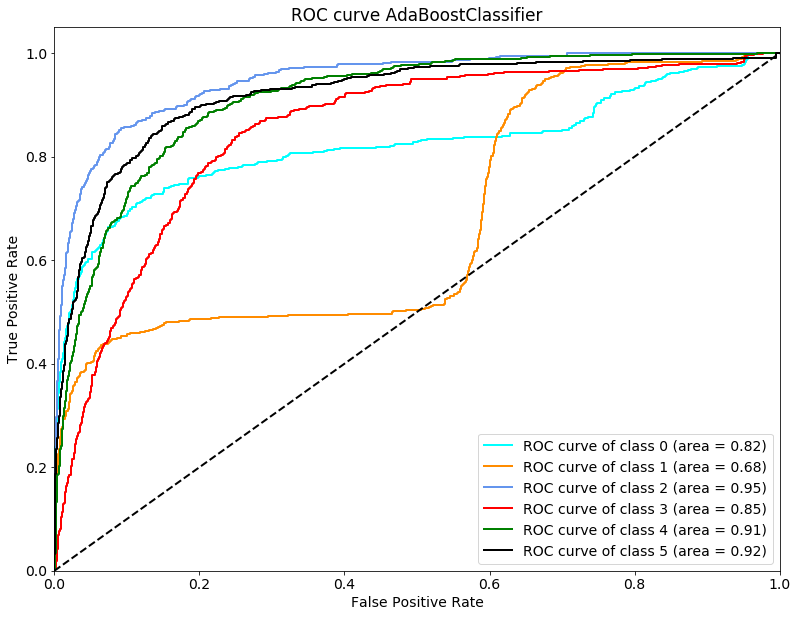

CPU times: user 1min 59s, sys: 147 ms, total: 1min 59s
Wall time: 4min 40s


In [31]:
%%time
parameters = {'n_estimators': [50, 100, 150, 200], 'learning_rate': [1.0, 1.2, 1.5, 2.0]}
get_all_results(AdaBoostClassifier, parameters, X_train_new, y_train_new, X_test_new, y_test_new)

# SGD

In [32]:
from sklearn.linear_model import SGDClassifier

/Users/igor/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'eta0': 0.5, 'learning_rate': 'adaptive', 'penalty': 'l2', 'shuffle': True}
              precision    recall  f1-score   support

           0       0.41      0.61      0.49       496
           1       0.48      0.43      0.45       471
           2       0.48      0.71      0.57       420
           3       0.41      0.20      0.27       491
           4       0.36      0.33      0.35       532
           5       0.64      0.54      0.58       537

    accuracy                           0.46      2947
   macro avg       0.46      0.47      0.45      2947
weighted avg       0.46      0.46      0.45      2947



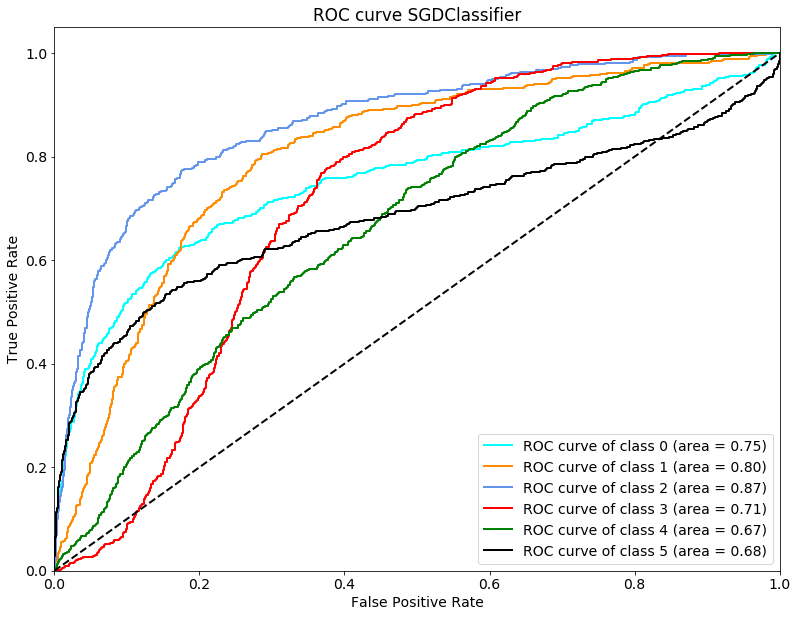

CPU times: user 2.64 s, sys: 127 ms, total: 2.77 s
Wall time: 12.5 s


In [33]:
%%time
parameters = {'penalty': ['l2', 'l1'], 'shuffle': [True, False],
              'learning_rate': ['optimal', 'invscaling', 'adaptive'], 'eta0': [0.01, 0.5]}
get_all_results(SGDClassifier, parameters, X_train_new, y_train_new, X_test_new, y_test_new)

# HistGradientBoostingClassifier

In [34]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

/Users/igor/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'l2_regularization': 0, 'learning_rate': 0.5}
              precision    recall  f1-score   support

           0       0.83      0.61      0.70       496
           1       0.60      0.94      0.74       471
           2       0.82      0.72      0.77       420
           3       0.74      0.73      0.73       491
           4       0.81      0.73      0.77       532
           5       0.89      0.86      0.87       537

    accuracy                           0.76      2947
   macro avg       0.78      0.76      0.76      2947
weighted avg       0.79      0.76      0.77      2947



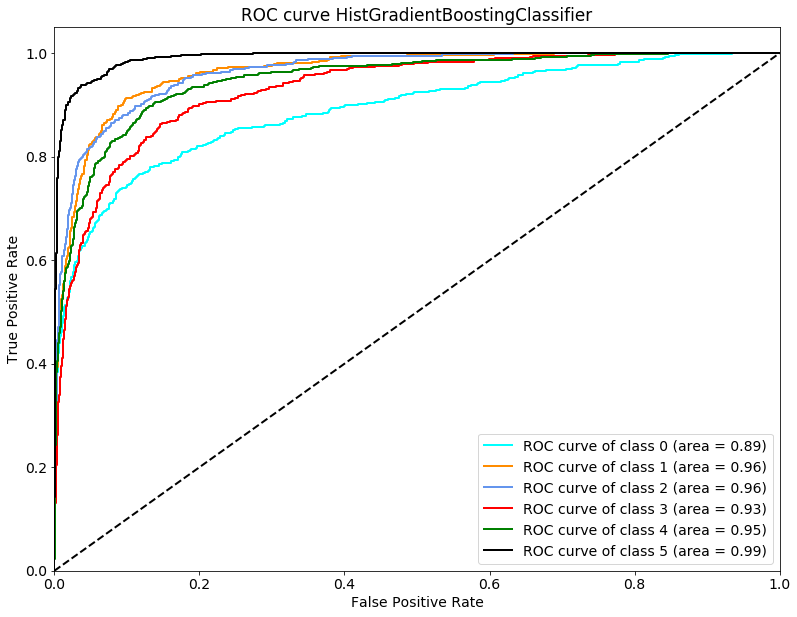

CPU times: user 2min 48s, sys: 1min 7s, total: 3min 55s
Wall time: 4min 12s


In [35]:
%%time
parameters = {'learning_rate': [0.1, 0.05, 0.01, 0.5],
              'l2_regularization': [0, 1]}
get_all_results(HistGradientBoostingClassifier, parameters, X_train_new, y_train_new, X_test_new, y_test_new)